<a href="https://colab.research.google.com/github/pedro-de-bastos/Machine-Learning-for-Science-and-Profit-CS156/blob/master/Identifying_Emotions_from_Facial_Expressions_Using_Neural_Networks_CS156_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotions: Natural Kinds or Constructions? Can Computers Read Them?

CS156 Final Project, Prof. Sterne

Pedro Martins de Bastos

## Background and Investigative Aims

For the past few decades, there has been a debate waging in the realm of cognitive sciences, and specifically within the subject of theories of emotions. On one hand, we have Dr. Paul Ekman, who defends the existence of 'natural kinds' of emotions. His work focuses on facial expressions and their universality, and on creating lie detectors that can unveil those emotions (Ekman, 1997). These natural kinds constitute the basic, familiar names we use: "joyful, angry, disgusted, fearful". 

On the other hand, we had Dr. Lisa Barrett, who defends a constructivist approach. Her claim is that the brain is a bayesian guessing machine, and that we interpret emotions based on several contextual factors (Barret, 2006). For her, a 'frown' might mean sadness in some contexts, and it might mean disappointment in others. The decision of how to classify the emotion comes down to 'nuance', and furthermore there is no "correct" answer.

Thus, with this project I intend to explore a Kaggle dataset with around 30,000 training set images whose images have already been 'correctly' classified as having one of 7 emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral (Pierre-Luc, & Aaron, 2013). 

Please find the exact dataset I used here: https://drive.google.com/open?id=1JZtiQ9FAyU4tyMvY06hlm5_BZRthhcxq.

## Investigating the Matter of Natural Kinds Using PCA

I first investigate the dataset using PCA to discover which are the most definitive components of a facial expression, and whether there are (a) a few important components defining the expressions which suggests 'natural kinds', or (b) countless important components suggesting a more nuanced, 'constructed' expression.

### Importing Data

The data in the Kaggle website was presented in a CSV table. The first column was the classification of the emotion presented in the person's face classified as such:  (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

The second column contained a string of values for the black and white pixels that encode the faces. Below I decode each string entry and encode them as numpy arrays.

In [ ]:
import pandas as pd
import numpy as np

rawtrain = pd.read_csv("/content/drive/My Drive/CS156/CS156_FP_IMGS/train.csv")
train = rawtrain.copy()
for i, j in enumerate(train['pixels']):
  newj = np.asarray(j.split())
  newj = newj.astype(np.float)
  train['pixels'][i] = newj

rawtest = pd.read_csv("/content/drive/My Drive/CS156/CS156_FP_IMGS/test.csv")
test = rawtest.copy()
test.columns = ['emotion', 'pixels']
for i, j in enumerate(test['pixels']):
  newj = np.asarray(j.split())
  newj = newj.astype(np.float)
  test['pixels'][i] = newj

def process_xs_ys(data): 
  dummytrain = pd.get_dummies(data, columns=['emotion']) 
  #This line gets dummy variables for all 7
  #emotions in my dataset so that I can use them
  #with the algorithms below
  y = dummytrain[['emotion_0', 'emotion_1', 'emotion_2', 'emotion_3', 'emotion_4', 'emotion_5', 'emotion_6']]
  X = []
  for i in data['pixels']:
    X.append(i)

  X = np.asarray(X)

  #Creating a Keras appropriate version of the dataset:
  import PIL
  import keras
  Xrich = []

  for i in range(len(X)):
    test = X[i].reshape(48, 48)
    Imagetest = PIL.Image.fromarray(test, mode="RGB")
    processed = keras.preprocessing.image.img_to_array(Imagetest)
    Imagetest.close()
    Xrich.append(processed)
  Xrich = np.asarray(Xrich)
  #Note that, above, I used the PIL and Keras libraries to (a) convert 
  #my grayscale array to images with a three channel RGB format, and to 
  #(b) convert these images back to arrays ready for processing. I had to do
  #this because the VGG16 algorithm I use below expects a three channel 
  #input (RGB rather than grayscale)
  return(y, Xrich)

y, Xrich = process_xs_ys(train)
y_test, Xrich_test = process_xs_ys(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Having decoded the face images above, I visualize the first 32 of them using matplotlib below, to make sure that the data truly translates to images:

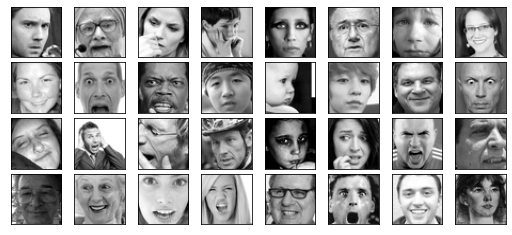

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

train_slice = train['pixels'][0:32]

for i, ax in enumerate(axes.flat):
    ax.imshow(train_slice[i].reshape(48, 48), cmap='binary_r')

### PCA Decomposition

In [ ]:
!pip install sklearn

In [ ]:
#Here I decompose each image into 50 principal components
from sklearn.decomposition import PCA

def pca_dec(pixel_series, n):
  pca = PCA(n)8
  lst = []
  for i in pixel_series:
    lst.append(i)

  lst = np.asarray(lst)
  X_dec = pca.fit_transform(lst)
  return X_dec, pca

X_dec50, pca50 = pca_dec(train['pixels'], 50)

In [ ]:
#How much of the variance do the first 50 components explain?
sum(pca50.explained_variance_ratio_)

NameError: ignored

In [ ]:
#How about for the first 150 components?
X_dec150, pca150 = pca_dec(train['pixels'], 150)
X_dec150_test, pca150_test = pca_dec(test['pixels'], 150)
sum(pca150.explained_variance_ratio_)

0.9231200223831664

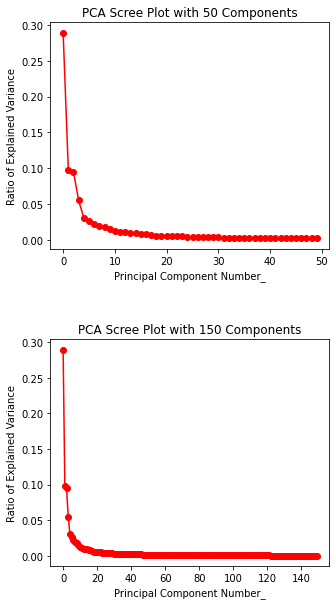

In [ ]:
#Building a scree plot for both:
comp_lst = [pca50.explained_variance_ratio_, pca150.explained_variance_ratio_]
comp_names = ["PCA Scree Plot with 50 Components", "PCA Scree Plot with 150 Components"]

fig, axes = plt.subplots(2, 1, figsize=(5, 10), gridspec_kw=dict(hspace=0.4, wspace=0.1))
for i, ax in enumerate(axes.flat):
  ax.set_title(comp_names[i])
  ax.set_xlabel("Principal Component Number_")
  ax.set_ylabel("Ratio of Explained Variance")
  ax.plot(range(len(comp_lst[i])),comp_lst[i], 'ro-')

As we can see, the scree plot is similar for both decompositions. For both, there is an exponential drop in the amount of variance explained, and the most important principle components explain a little under 0.3 (30%) of the variance. Because of the exponential nature between the principle components and the explained variance, we have that with 50 components we explain around 84% of the total variance, and with 150 principle components, we explain around 92% of the variance, even though we tripled the number of components. Moving forward, I will focus on using the 150 decomposition because of the increased variance explained, albeit I'd expect my classificaiton algorithms to run more slowly for 150 than for 50.

### Reconstruction of Principal Components

Now that I have decomposed each image into 150 principal components, we can have a look into how the first few components look like, and determine whether we can glean some insight into the research quesiton:

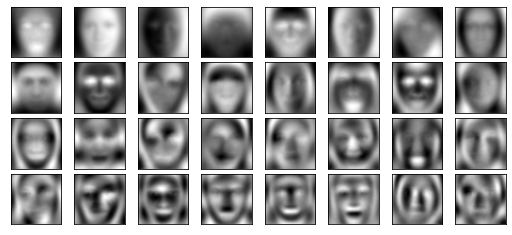

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

components = pca150.components_[0:32]

for i, ax in enumerate(axes.flat):
    ax.imshow(components[i].reshape(48, 48), cmap='binary_r')

These don't look very conclusive at a first glance! But perhaps by examining a few of them more closely we can determine something about the emotional range. Let us focus first on the first image. 

The first principal component is an eigenvector with 48x48 components. We can investigate how the dimensions change by multiplying that eigenvector with two different eigenvalues, and noting how the image changes:

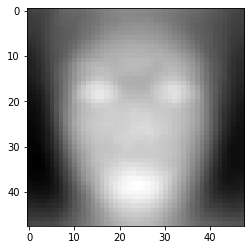

In [ ]:
#Plotting the priciple component for a 'large' and for a 'small' eigenvector
large = components[0]*100
small = components[0]*-50
plt.imshow(large.reshape(48, 48), cmap='binary_r') #Large first

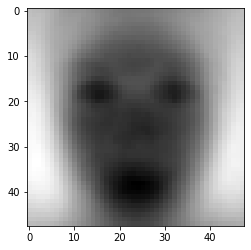

In [ ]:
plt.imshow(small.reshape(48, 48), cmap='binary_r') #now small

This eigenvector seems to be concerned mostly with differentiating the contrast between the face's color and the background color, and not very much with differences in face expression. 

Looking at the grid of principle components above, it seems to me like number 14 might encode a smile versus a frown, or something in that ballpark. Let us take a look again:

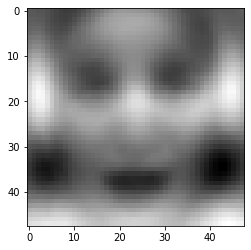

In [ ]:
#Plotting the priciple component for a 'large' and for a 'small' eigenvector
large = components[17]*100
small = components[17]*-50
plt.imshow(large.reshape(48, 48), cmap='binary_r') #Large first

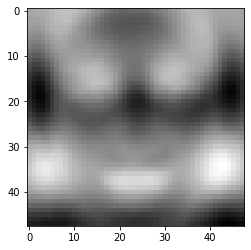

In [ ]:
plt.imshow(small.reshape(48, 48), cmap='binary_r') #now small

### Discussion and PCA Conclusions

First of all, other than finding out how unnerving the principle components look, I don't think that the visualization of the components lends anything conclusive to the discussion. If there were at least a few principle components that clearly encoded emotions on two opposite ends of the spectrum, like "happy" versus "sad", that might have been strong support for the 'natural kinds' hypothesis, but I found no evidence of this (granted I did not investigate thoroughly every single component).

The scree plots, however, can perhaps be more informative. Note how there is an exponential drop in variance explanation, and that subsequent principle components after the first few add only incremental explanation. This could point towards nuance intrinsic to human emotion. Of course, these principle components also encode several features pertaining to face structure, skin color, hair, and others, such that making any delimitations based on them alone is ill advised. That said, if the scree plots really are evidence of the existence of considerable nuance, that may be an argument pro constructivism of emotions. A 'natural kinds' situation might entail few, distinguishing features for each emotion, but thats not what we are seeing: looking at the visualizations, some seem to encode eye shape, eyebrow inflection, mouth shape, and all in all 150 features (which together explain only 92% of the faces and expressions).

## Can Convolutional Neural Networks Read Emotions? Using VGG16 Transfer Learning to Find Out

### Training the Model

In [ ]:
#First trying out a simple model with no filters/convolutions, using the PCA data
pca_model = Sequential()
pca_model.add(Dense(12, input_dim=150, activation='relu'))
pca_model.add(Dense(8, activation='relu'))
pca_model.add(Dense(7, activation='sigmoid')) 
#There are seven units in the output layer to represent the seven categories for
#different emotions. The sigmoid activation function furthermore allows us to 
#investigate the probabilities for each category given an input.


pca_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

pca_model.fit(X_dec150, y, validation_data=(X_dec150_test, y_test), epochs=10, batch_size=100)

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 1s 21us/step - loss: 13.9044 - accuracy: 0.6616 - val_loss: 1.7528 - val_accuracy: 0.7947
Epoch 2/10
28709/28709 [==============================] - 0s 17us/step - loss: 1.0365 - accuracy: 0.8257 - val_loss: 0.7941 - val_accuracy: 0.8380
Epoch 3/10
28709/28709 [==============================] - 0s 16us/step - loss: 0.6320 - accuracy: 0.8465 - val_loss: 0.5995 - val_accuracy: 0.8471
Epoch 4/10
28709/28709 [==============================] - 0s 16us/step - loss: 0.5235 - accuracy: 0.8521 - val_loss: 0.5234 - val_accuracy: 0.8503
Epoch 5/10
28709/28709 [==============================] - 0s 15us/step - loss: 0.4732 - accuracy: 0.8545 - val_loss: 0.4846 - val_accuracy: 0.8518
Epoch 6/10
28709/28709 [==============================] - 0s 16us/step - loss: 0.4443 - accuracy: 0.8557 - val_loss: 0.4585 - val_accuracy: 0.8530
Epoch 7/10
28709/28709 [==============================] - 0s 15us/st

In [ ]:
#Trying out feature extraction with VGG16
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, input_tensor=None, input_shape=(48, 48, 3), classes=7)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Extracting features for the training set
features = model.predict(x=Xrich)
features = features.reshape(28709, 512)

#Extracting features for the test set
features_test = model.predict(x=Xrich_test)
features_test = features_test.reshape(7178, 512)

In [ ]:
#Builiding a feedforward neural network to operate on top of the extracted
#features from VGG16
#Note that the model below was inspired by (Sarkar, 2018)
VGG16_model = Sequential()
VGG16_model.add(Dense(512, input_dim=512, activation='relu'))
VGG16_model.add(Dropout(0.3)) #Dropout layers help prevent overfitting by
                              #setting a random fraction of inputs to zero
                              #thereby throwing the network a 'curveball' and 
                              #forcing it to re-adjust
VGG16_model.add(Dense(512, activation='relu'))
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(7, activation='sigmoid'))

VGG16_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
VGG16_model.fit(features, y, validation_data=(features_test, y_test), epochs=10)

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 8s 273us/step - loss: 0.5901 - accuracy: 0.8247 - val_loss: 0.4090 - val_accuracy: 0.8571
Epoch 2/10
28709/28709 [==============================] - 8s 267us/step - loss: 0.4036 - accuracy: 0.8558 - val_loss: 0.4004 - val_accuracy: 0.8570
Epoch 3/10
28709/28709 [==============================] - 8s 272us/step - loss: 0.3980 - accuracy: 0.8569 - val_loss: 0.4008 - val_accuracy: 0.8571
Epoch 4/10
28709/28709 [==============================] - 8s 271us/step - loss: 0.3954 - accuracy: 0.8570 - val_loss: 0.4012 - val_accuracy: 0.8571
Epoch 5/10
28709/28709 [==============================] - 8s 271us/step - loss: 0.3938 - accuracy: 0.8571 - val_loss: 0.4032 - val_accuracy: 0.8572
Epoch 6/10
28709/28709 [==============================] - 8s 265us/step - loss: 0.3928 - accuracy: 0.8571 - val_loss: 0.4057 - val_accuracy: 0.8572
Epoch 7/10
28709/28709 [==============================] - 8s 26

## Evaluating the Models and Conclusion



The most important metric we want to look at to evaluate the two models above, the PCA based neural network and the VGG16 transfer learning neural network, is the validation accuracy (shown in the output of the fit process). For the PCA model, we had a validation accuracy of 85.42%, and for the VGG16 model, we had a validation accuracy of 85.72%. It is remarkable how close these two results are, given that the first is a very simple model running on simplified data, and that the second is based on features extracted from an award winning algorithm. The VGG16 model took 1 min 20 seconds to train, and another 3 minutes for the feature extraction process (a total of 4 minutes and 20 seconds). The PCA model, however, took only 3 seconds to train, with the PCA decomposition step taking around 1 minute (roughly 1 minute and 3 seconds). This means a tradeoff of 3 minutes and 17 seconds for an imporvement of 0.3% in accuracy. This is not to mention the time and effort that was spent to develop the VGG16 algorithm, versus using a much simpler neural network on top of PCA decomposed images.

What can these accuracy values tell us about the research question? Both of these rates were very high. These are rates similar to what some professionals get in classification tasks with more definitive categories (Shorten, 2018, discusses a similar approach for the classification of images as being either of a dog or of a cat, and his accuracy rate was of around 72%).

There are strong arguments for the categories 'dogs' and 'cats' being natural, rather than human constructs. We might go by the traditional biological cutoff for speciation: these two animals can neither breed together, nor produce fertile offspring (Endler, 1977). The point is that our neural network does better at categorizing emotions than similar networks do on categorizing scientifically discrete categories. This is support to the existence of at least some clearly distinguishable categories for facially expressed emotions. 

Of course, those who oppose the existence of discrete, natural categories of emotions would argue that they don't disagree that we can't make good guesses about someone's emotions. They would argue specifically that the way we display emotions is strongly reliant on cultural factors, and therefore that we may be able to label someone's facial expression due to cultural conventions, and not due to a deep knowledge of immutable, discrete categories.

There are further limitations to my approach. First, our sample could be biased. If we are investigating the 'universality' of emotional categories, then it would be troubling to have all of our images belong to people of a particular country (I did not find particular descriptions about the population for this image set). Second, there may be bias in how the researchers chose and categorized these images (note that not only did researchers impose the existence of seven categories for emotions, but they also looked for images that fit their own undrstanding of these categories). These worries are somewhat counterbalanced by the large size of the dataset.

Certainly looking at facial expressions could only ever be a piece of the puzzle, and not definitive proof for either side of the argument. Nonetheless, this project highlights how even a modest application of machine learning can provide us with valuable insights on how the human mind works. Today researchers are using similar neural networks to investigate brain pathways that may underlie emotional processes, thereby looking at this problem at a different level of analysis (Raz, Winetraub, Jacob, Kinreich, Maron-Katz, Shaham, & Hendler, 2012).

# References

Barrett, L. F. (2006). Are emotions natural kinds?. Perspectives on psychological science, 1(1), 28-58.

Ekman, P. (1997). Deception, lying, and demeanor. States of mind: American and post-Soviet perspectives on contemporary issues in psychology, 93-105.

Endler, J. A. (1977). Geographic variation, speciation, and clines (No. 10). Princeton University Press.

Pierre-Luc, C., & Aaron, C. (2013). Challenges in Representation Learning: Facial Expression Recognition Challenge. Retrieved April 23, 2020, from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/overview

Raz, G., Winetraub, Y., Jacob, Y., Kinreich, S., Maron-Katz, A., Shaham, G., ... & Hendler, T. (2012). Portraying emotions at their unfolding: a multilayered approach for probing dynamics of neural networks. Neuroimage, 60(2), 1448-1461.

Sarkar. (2018, November 17). A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning. Retrieved April 23, 2020, from https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a